Some information about the project:

1. Define the problem you dealing with
2. Defining the data and which way is best to retrive it
3. Analyzing the data you have retrived
4. Visualize EDA
5. Further data investigation (which algorithems to use)
6. Solution implementation

The exersice: <br/>
Crawl over book deposit website, generate a dataset. <br/>
and make a model that can predict rather the book will be best seller or not


In [21]:
# Used for enable to see the result in the notebook
%matplotlib inline

from bs4 import BeautifulSoup

import requests
import pandas as pd
import time
from random import randrange

from typing import Final, Any
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

For this our data source will be `https://www.bookdepository.com`. Let's fetch some data

# 1. Fetching all data

In [22]:
# Number of pages to crawl each page contain 30 books
NUMBER_OF_PAGES: Final[int] = 2
URL: Final[str] = 'https://www.bookdepository.com/search?searchLang=<language-id>&page=<page-number>' # Example url: 'https://www.bookdepository.com/search?searchLang=123&page=1'

In [23]:
# TODO: Make this function async

# Loading soup object by url address
async def get_soup_obj(url: str) -> BeautifulSoup:
    try:
        r = requests.get(url)
    except Exception as ex:
        print(f'Failed to request {url}:', ex)
        
    soupObj = BeautifulSoup(r.content, 'html.parser')
    return soupObj

In [174]:
# Extracting features from the given page
def getTitle(soupObj: BeautifulSoup) -> str:
    title_name_tag: BeautifulSoup = soupObj.find('h1', { 'itemprop': 'name' })
    return title_name_tag.text.strip() if title_name_tag is not None else None
    
def getPagesCount(soupObj: BeautifulSoup) -> int:
    pages_count_tag: BeautifulSoup = soupObj.find('span', {'itemprop': 'numberOfPages'})
    return int(pages_count_tag.text.strip().replace(' pages', '')) if pages_count_tag is not None else None
    
def getDatePublished(soupObj: BeautifulSoup) -> str:
    date_published: BeautifulSoup = soupObj.find('span', {'itemprop': 'datePublished'})
    return date_published.text.strip() if date_published is not None else None
    
def getCategory(soupObj: BeautifulSoup) -> list[str]:
    item_ol: BeautifulSoup = soupObj.find('ol', {'class': 'breadcrumb'})
    if item_ol is None:
        return None

    return { t.text.strip() for t in item_ol('a') }

def getBestSellerRank(soupObj: BeautifulSoup) -> int:
    biblio_info: BeautifulSoup = soupObj.find('ul', {'class':'biblio-info'})
    if biblio_info is None or biblio_info('li') == []:
        return None

    return int(biblio_info('li')[-1].find('span').text.strip().replace(',', ''))

def getRating(soupObj: BeautifulSoup) -> float:
    book_rating: BeautifulSoup = soupObj.find('span', {'itemprop': 'ratingValue'})
    return float(book_rating.text.strip()) if book_rating is not None else None
     
def ratingCount(soupObj: BeautifulSoup) -> int:
    rating_count: BeautifulSoup = soupObj.find('meta', {'itemprop': 'ratingCount'})
    return int(rating_count['content']) if  rating_count is not None else None

def getAuthor(soupObj: BeautifulSoup) -> str:
    author: BeautifulSoup = soupObj.find('span', {'itemprop': 'name'})
    return author.text.strip() if author is not None else None

def getBackType(soupObj: BeautifulSoup) -> str:
    backtype_ul: BeautifulSoup = soupObj.find('ul',{'class':'meta-info hidden-md'})
    return backtype_ul.find('li').text.strip() if backtype_ul is not None else None

def getPrice(soupObj: BeautifulSoup) -> float:
    book_price: BeautifulSoup = soupObj.find('span', {'class': 'sale-price'})
    
    #ValueError
    if book_price is not None:
        try:
            return float(book_price.text.strip()[1:]) 
        except ValueError:
            return None
    return None
    
def getUrlOfGoodReads(url: str) -> str:
    s: BeautifulSoup = get_soup_obj(url)
    
    exit_to_goodreads: BeautifulSoup = s.find('a', {'class':'exit-to-goodreads'}) 
    if exit_to_goodreads is not None:
        return 'https://www.goodreads.com/book/show' + exit_to_goodreads['href'].replace('/external/GR','')

    return None

def extractNumberOfTextReviews(goodreads_url: str):
    if not goodreads_url:
        return None

    # for i in range(10):
        # time.sleep(randrange(1, 3))
    
    # Getting goodreads html content
    s: BeautifulSoup = get_soup_obj(goodreads_url)
    number_of_text_reviews: BeautifulSoup = s.find('meta', {'itemprop': 'reviewCount'})
    
        # if number_of_text_reviews:
            # break

    if not number_of_text_reviews:
        return None
        
    return number_of_text_reviews['content']

def get_dimensions(soup_obj: BeautifulSoup) -> list[int]:
    dimentions_tag: BeautifulSoup = soup_obj.find('ul', { 'class': 'biblio-info' })
    dimensions_span: BeautifulSoup = dimentions_tag.find_all('span')[2]
    
    return [dimensions_span.get_text().replace(r'/\D+/g', ',')]


To manage our data more simply, Let's create some data structure ("object" or "class") to help us

In [93]:
class Row:
    author: str
    title: str
    page_count: int
    date_published: str
    category: str
    bestsellers_rank: int
    rating: float
    rating_count: int
    back_type: str
    ILS_price: float
    width: int = 0
    height: int
    thickness: int
    weight: int

    def __init__(
        self, author: str = None, title: str = None, page_count: int = 0,
        date_published: str = None, category: str = None,
        bestsellers_rank: int = 0, rating: float = 0, rating_count: int = 0,
        back_type: str = None, ILS_price: float = 0, 
        width: int = 0, height: int = 0, thickness: int = 0, weight: int = 0
    ):
        self.author = author
        self.title: str = title
        self.page_count: str = page_count
        self.date_published: str = date_published
        self.category: str = category
        self.bestsellers_rank: str = bestsellers_rank
        self.rating: str = rating
        self.rating_count: str = rating_count
        self.back_type: str = back_type
        self.ILS_price: str = ILS_price
        self.width: str = width
        self.height: str = height
        self.thickness: str = thickness
        self.weight: str = weight

    def to_dict(self) -> dict[str, Any]:
        return {
            'author': self.author,
            'title': self.title,
            'page_count': self.page_count,
            'date_published': self.date_published,
            'category': self.category,
            'bestsellers_rank': self.bestsellers_rank,
            'rating': self.rating,
            'rating_count': self.rating_count,
            'back_type': self.back_type,
            'ILS_price': self.ILS_price,
            'width': self.width,
            'height': self.height,
            'thickness': self.thickness,
            'weight': self.weight
        }

    @classmethod
    def get_cols(self) -> dict[str, list]:
        """
        This funciton will return the columns structure of a row. 
        Which means, a dictionary with columns names as a key and empty list as a value.
        
        Definition:
        {
            [column_name: str]: []
        }
        """
        default_dict: dict[str, Any] = Row().to_dict()
        for key in default_dict:
            default_dict[key] = []

        return default_dict
        

In [166]:
# Extract properties book by book to a list 
def get_prop(soupObj: BeautifulSoup) -> Row:
    print(get_dimensions(soupObj))
    width, height, thickness, weight = get_dimensions(soupObj)

    prop: Row = Row(
        getAuthor(soupObj), getTitle(soupObj), getPagesCount(soupObj),
        getDatePublished(soupObj), getCategory(soupObj), getBestSellerRank(soupObj),
        getRating(soupObj), ratingCount(soupObj), getBackType(soupObj), getPrice(soupObj),
        # width, height, thickness, weight
    )

    return prop

In [167]:
# Crawl the urls of the books from the main page
# page after page
def exctractBooksUrls(pages: int) -> list[str]:
    books_urls = []
    site_domain: str = 'https://www.bookdepository.com'

    for i in range(pages):
        url: str = f'{site_domain}/search?searchLang=123&page={i + 1}'
        print('page number', i + 1, url)

        currentPage: BeautifulSoup = get_soup_obj(url)
        items = currentPage('div', {'class': 'book-item'})
        
        for book in items:
            book_url = book.find('h3').find('a')['href']
            books_urls.append(f'{site_domain}{book_url}')    

    return books_urls
    

In [96]:
def buildDictForDataFrame(booksUrls: list[str]) -> dict[str, list]:
    df_dict: dict[str, list] = Row.get_cols()

    counter: int = 0
    for url in booksUrls:
        counter += 1
        print('book number', counter)

        book_soup = get_soup_obj(url)
        book: dict[str, Any] = get_prop(book_soup).to_dict()
        
        for key in book:
            df_dict[key].append(book[key])
            
    return df_dict

In [34]:
def getUrlOfGoodReads(url: str):
    s: BeautifulSoup = get_soup_obj(url)
    exit_to_goodreads = s.find('a', {'class':'exit-to-goodreads'}) 

    if exit_to_goodreads is not None:
        return 'https://www.goodreads.com/book/show' + exit_to_goodreads['href'].replace('/external/GR','')
    
    return None

In [35]:
# def extractNumberOfTextReviews(url: str):
#     found: bool = True
#     if not url:
#         return None

#     for i in range(10):
#         s: BeautifulSoup = get_soup_obj(url)
#         number_of_text_reviews = s.find('meta', {'itemprop': 'reviewCount'})
#         if number_of_text_reviews:
#             break

#     if not number_of_text_reviews:
#         return None
        
#     return number_of_text_reviews['content']


In [99]:
def buildListOfUrl(path: str):
    l = []

    with open(path, 'r') as f:
        l = f.read().split('\n')
        
    return l

In [37]:
def load_csv(path: str) -> None:
    return pd.read_csv(path)

In [100]:
books_urls = exctractBooksUrls(3)

page number 1 https://www.bookdepository.com/search?searchLang=123&page=1
page number 2 https://www.bookdepository.com/search?searchLang=123&page=2
page number 3 https://www.bookdepository.com/search?searchLang=123&page=3


In [175]:
df_dict: dict[str, Any] = buildDictForDataFrame(books_urls)
print(df_dict.keys())

book number 1
['\n                                130\n                                    x 198\n                                    x 27mm\n                                \n                                    | 270g\n                                ']


ValueError: not enough values to unpack (expected 4, got 1)

In [40]:
ctr: int = 1
for url in books_urls:
    print('good reads', ctr)
    ctr += 1
    
    gr_url = getUrlOfGoodReads(url)
    df_dict['text-reviews-count'].append(extractNumberOfTextReviews(gr_url))

good reads 1
good reads 2
good reads 3
good reads 4
good reads 5
good reads 6
good reads 7
good reads 8
good reads 9
good reads 10
good reads 11
good reads 12
good reads 13
good reads 14
good reads 15
good reads 16
good reads 17
good reads 18
good reads 19
good reads 20
good reads 21
good reads 22
good reads 23
good reads 24
good reads 25
good reads 26
good reads 27
good reads 28
good reads 29
good reads 30
good reads 31
good reads 32
good reads 33
good reads 34
good reads 35
good reads 36
good reads 37
good reads 38
good reads 39
good reads 40
good reads 41
good reads 42
good reads 43
good reads 44
good reads 45
good reads 46
good reads 47
good reads 48
good reads 49
good reads 50
good reads 51
good reads 52
good reads 53
good reads 54
good reads 55
good reads 56
good reads 57
good reads 58
good reads 59
good reads 60


In [41]:
df = pd.DataFrame(df_dict)

In [42]:
df.head()

,title,pages-count,date-published,category,bestsellers-rank,rating,rating-count,text-reviews-count,author,back-type,price-ILS
0,It Ends With Us: The most heartbreaking novel ...,384,02 Aug 2016,"{Romance, Family & Relationships, Safety In Th...",2,4.43,573274,65345,Colleen Hoover,Paperback,46.55
1,Sapiens : A Brief History of Humankind,512,01 May 2015,"{Early Man, Social & Cultural History, History...",72,4.39,705951,42404,Yuval Noah Harari,Paperback,62.48
2,Dear Zoo : A Lift-the-flap Book,18,08 May 2007,"{Baby Books, Animal Stories}",184,4.28,23550,692,Rod Campbell,Board book,39.73
3,The Barefoot Investor : The Only Money Guide Y...,296,01 Jul 2018,"{Personal Finance, Investment & Securities, Fi...",7383,4.42,14836,1276,Scott Pape,Paperback,76.60
4,Milk and Honey,208,08 Jul 2016,"{Poetry By Individual Poets, Mind, Body & Spir...",291,4.03,469183,33454,Rupi Kaur,Paperback,53.20


Good work, now let's save this for further investigation

In [50]:
df.to_csv('../data/book_deposits.csv', index=False)

# 2. Visuallizing the data

First thing let's see what we are dealing with

In [51]:
df = pd.read_csv('../data/book_deposits.csv')
df.head()

,title,pages-count,date-published,category,bestsellers-rank,rating,rating-count,text-reviews-count,author,back-type,price-ILS
0,It Ends With Us: The most heartbreaking novel ...,384,02 Aug 2016,"{'Romance', 'Family & Relationships', 'Safety ...",2,4.43,573274,65345,Colleen Hoover,Paperback,46.55
1,Sapiens : A Brief History of Humankind,512,01 May 2015,"{'Early Man', 'Social & Cultural History', 'Hi...",72,4.39,705951,42404,Yuval Noah Harari,Paperback,62.48
2,Dear Zoo : A Lift-the-flap Book,18,08 May 2007,"{'Baby Books', 'Animal Stories'}",184,4.28,23550,692,Rod Campbell,Board book,39.73
3,The Barefoot Investor : The Only Money Guide Y...,296,01 Jul 2018,"{'Personal Finance', 'Investment & Securities'...",7383,4.42,14836,1276,Scott Pape,Paperback,76.60
4,Milk and Honey,208,08 Jul 2016,"{'Poetry By Individual Poets', 'Mind, Body & S...",291,4.03,469183,33454,Rupi Kaur,Paperback,53.20


How much types of `back-type` we have in this dataset?

<AxesSubplot:xlabel='back-type', ylabel='count'>

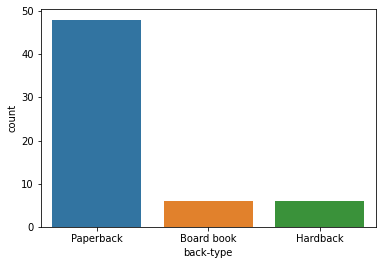

In [8]:
sns.countplot(x=df['back-type'])

Does we have a correlation between the price and the pages in the book?

<BarContainer object of 60 artists>

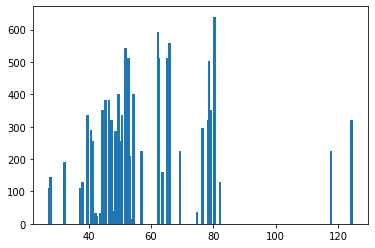

In [12]:
plt.bar(x=df['price-ILS'], height=df['pages-count'])

<AxesSubplot:xlabel='category', ylabel='count'>

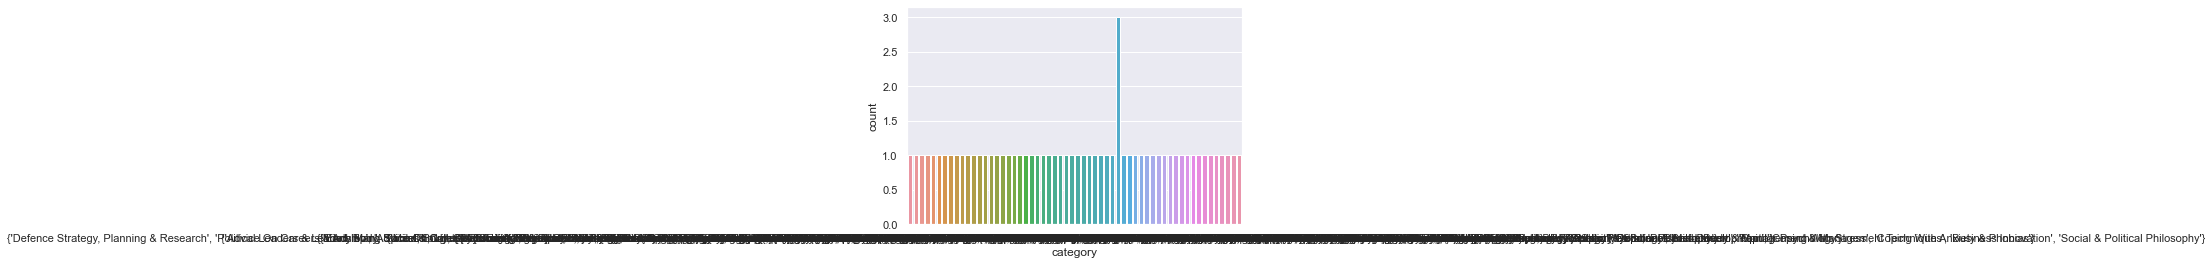

In [20]:
sns.countplot(x=df['category'])

Let's check for duplicates

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          60 non-null     int64  
 1   title               60 non-null     object 
 2   pages-count         60 non-null     int64  
 3   date-published      60 non-null     object 
 4   category            60 non-null     object 
 5   bestsellers-rank    60 non-null     int64  
 6   rating              60 non-null     float64
 7   rating-count        60 non-null     int64  
 8   text-reviews-count  60 non-null     int64  
 9   author              60 non-null     object 
 10  back-type           60 non-null     object 
 11  price-ILS           59 non-null     float64
dtypes: float64(2), int64(5), object(5)
memory usage: 5.8+ KB


In [17]:
titles = df[""]
df[titles.isin(titles[titles.duplicated()])]

,Unnamed: 0,title,pages-count,date-published,category,bestsellers-rank,rating,rating-count,text-reviews-count,author,back-type,price-ILS
